In [1]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
dde.config.real.set_float64()
a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
print(sys.executable)
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    a=2
    b=1
    r1=1
    r2=2
    r3=-1
    r4=4*a*b/(a**2+b**2)
    beta=1
    
    f_u1 = (
            v1_t + u1_xx
        + r1*u1*(u1**2 + v1**2) + r2*u1*(u2**2 + v2**2) + r3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + r4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

    f_v1 = (
            -u1_t + v1_xx
        + r1*v1*(u1**2 + v1**2) + r2*v1*(u2**2 + v2**2) - r3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - r4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
    )

    f_u2 = (
            v2_t + beta*u2_xx
        + r1*u2*(u2**2 + v2**2) + r2*u2*(u1**2 + v1**2) + r3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + r4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
    )

    f_v2 = (
            -u2_t + beta*v2_xx
        + r1*v2*(u2**2 + v2**2) + r2*v2*(u1**2 + v1**2) - r3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - r4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
    )
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 # 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

k1=1.5
k2=1
l1=1.5
l2=-1
nf1=0
nf2=0
ng1=0
ng2=0
k=complex(k1,-k2)
kk=k.conjugate()
l=complex(l1,-l2)
ll=l.conjugate()
nf=complex(nf1,-nf2)
nff=nf.conjugate()
ng=complex(ng1,-ng2)
ngg=ng.conjugate()


def init_cond_u1(x):
    f=np.exp((0-1j)*(k**2)*(-x[:,1:2]) + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*(-x[:,1:2]) + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result=q1.real
    
    
    #result=( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
     #      )
    return result
    
def init_cond_u2(x):
    f=np.exp((0-1j)*(k**2)*(-x[:,1:2]) + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*(-x[:,1:2]) + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result=q2.real
    #result=( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
      #     )
    return result

def init_cond_v1(x):
    f=np.exp((0-1j)*(k**2)*(-x[:,1:2]) + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*(-x[:,1:2]) + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result=-q1.imag
    
    #result=-( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result

def init_cond_v2(x):
    f=np.exp((0-1j)*(k**2)*(-x[:,1:2]) + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*(-x[:,1:2]) + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result= -q2.imag
    
    #result= ( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=50,
    num_initial=50,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 5 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)

c:\tools\Anaconda3\python.exe


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


c:\tools\Anaconda3\python.exe


In [15]:
model.compile("adam", lr=1e-3, loss="MSE")

model.train(epochs=100, display_every=100)

Compiling model...
'compile' took 3.109253 s

Training model...



KeyboardInterrupt: 

Compiling model...
'compile' took 2.313360 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
567       [1.26e-03, 1.12e-03, 2.75e-04, 6.00e-04, 6.24e-05, 1.00e-04, 3.69e-05, 1.57e-05, 5.37e-05, 1.66e-04, 1.58e-04, 1.38e-04, 4.40e-03, 5.49e-03, 9.95e-03, 5.79e-03]    [1.26e-03, 1.12e-03, 2.75e-04, 6.00e-04, 6.24e-05, 1.00e-04, 3.69e-05, 1.57e-05, 5.37e-05, 1.66e-04, 1.58e-04, 1.38e-04, 4.40e-03, 5.49e-03, 9.95e-03, 5.79e-03]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.027205
  Number of iterations: 46
  Number of functions evaluations: 84
651       [1.43e-03, 1.30e-03, 3.45

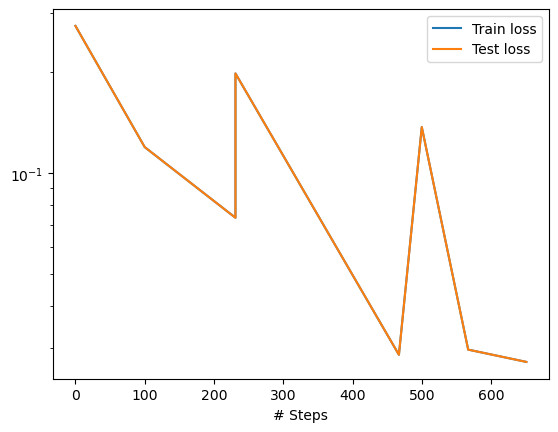

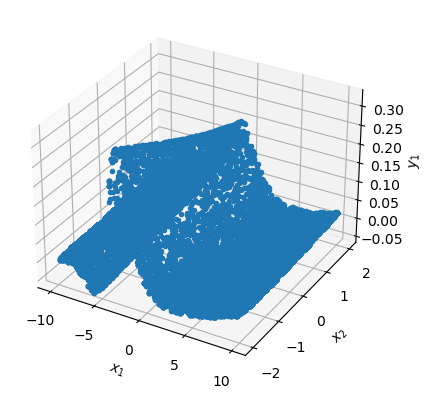

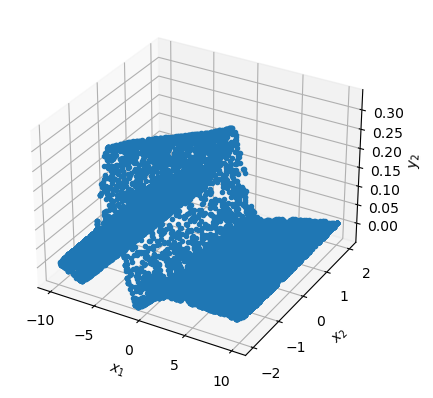

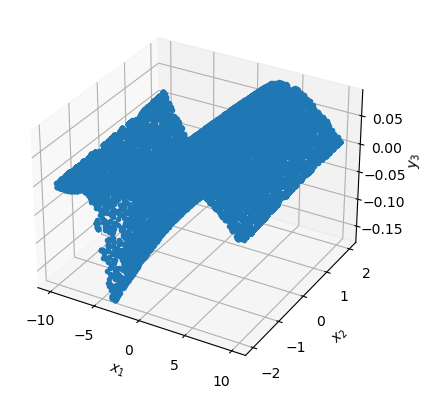

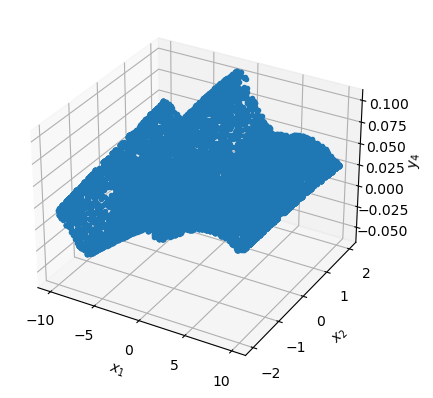

In [16]:

dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=0,
    gtol=1e-09,
    maxiter=10000,
    maxfun=20000,
    maxls=50,
)

model.compile("L-BFGS")
#model.train()

model.train_step.optimizer_kwargs = {'options': {'maxfun': 1e5, 'ftol': 1e-20, 'gtol': 1e-20, 'eps': 1e-20, 'iprint': -1, 'maxiter': 1e5}}
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

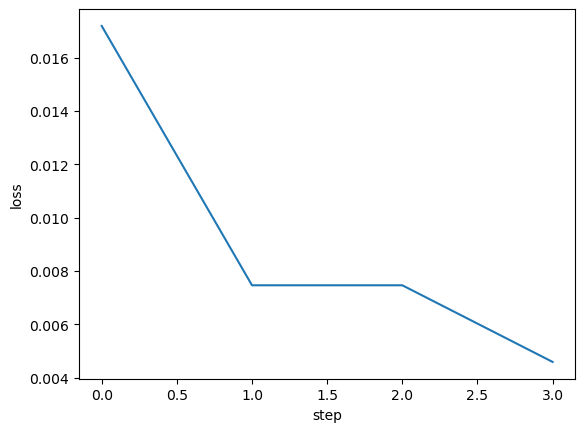

In [4]:

loss_t = losshistory.loss_train



plt.plot(np.mean(loss_t,axis=1))
plt.xlabel("step")
plt.ylabel("loss")

print(losshistory)
print(train_state)

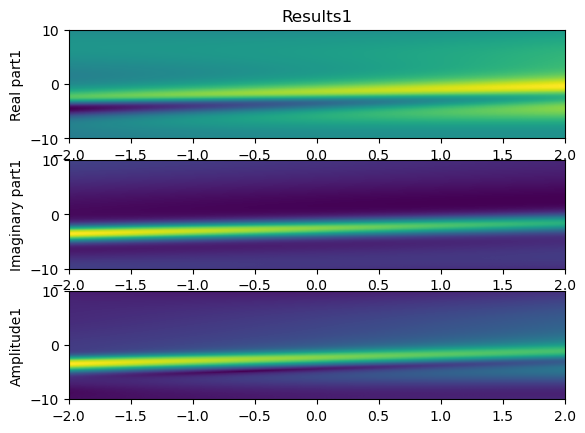

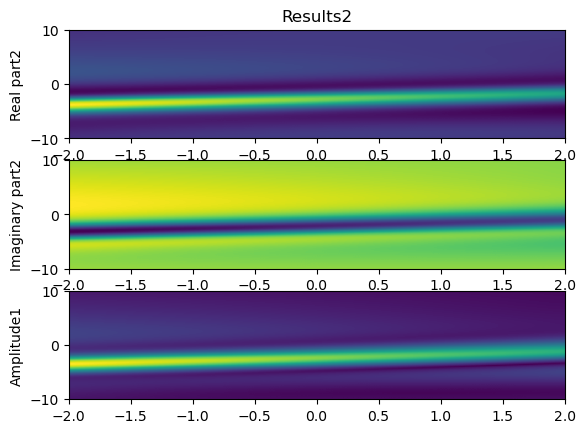

In [5]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()

[ 601  605  571 ... 7560 7409 7261]


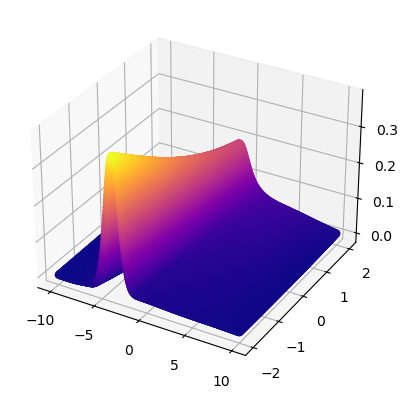

In [6]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:],cmap='plasma')

[6443 6374 6366 ...  833  821  807]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


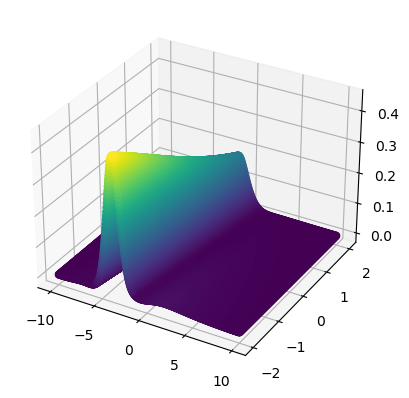

In [7]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [8]:
print(c)

2.6592366e-07


In [9]:
b=1
c=2
a=complex(b,c)
print(a)

(1+2j)


In [10]:
z=-1j
print(z)

(-0-1j)


In [11]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

k1=1.5
k2=1
l1=1.5
l2=-1
nf1=0
nf2=0
ng1=0
ng2=0
k=complex(k1,-k2)
kk=k.conjugate()
l=complex(l1,-l2)
ll=l.conjugate()
nf=complex(nf1,-nf2)
nff=nf.conjugate()
ng=complex(ng1,-ng2)
ngg=ng.conjugate()

X = np.arange(-10, 10, 0.01)
T = np.arange(-2, 2, 0.01)
x, t = np.meshgrid(X, T)

f=np.exp((1j)*(k**2)*(t) + k*x+ nf)
ff=f.conjugate()
g=np.exp((1j)*(l**2)*(t) + l*x+ ng)
gg=g.conjugate()
phi1=1+2*f*ff/((k+kk)**2)
phi2=1+2*g*gg/((l+ll)**2)
Q1=f/phi1+g/phi2
Q2=1j*(f/phi1-g/phi2)


c:\tools\Anaconda3\python.exe


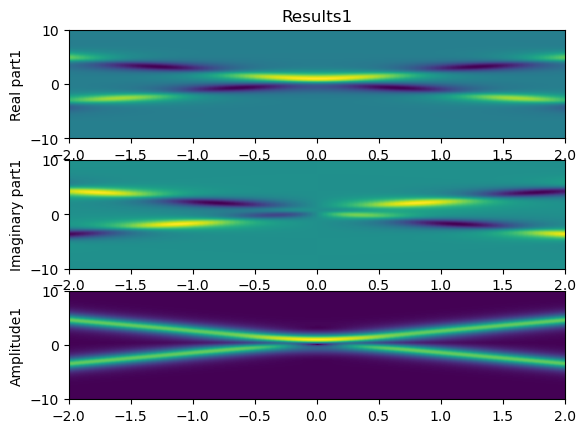

In [12]:
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2


fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    Q2.real.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    Q2.imag.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    np.abs(Q2).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
